In [14]:
%matplotlib inline
from datasets import load_from_disk
from pyvenn import *

## 加载验证数据集

In [6]:
def load_validation_dataset(dataset_name):
    dataset=load_from_disk(f'../defects4j_validation/dataset_validated/{dataset_name}')
    print(f' \n==========\n{dataset_name}\n==========\n',dataset)
    return dataset

In [7]:
codellama_vanilla=load_validation_dataset('codellama_vanilla')
codellama_classinfo=load_validation_dataset('codellama_classinfo')
codellama_classinfo_lora=load_validation_dataset('codellama_classinfo_lora')
codellama_no_classinfo_lora=load_validation_dataset('codellama_no_classinfo_lora')
repairllama=load_validation_dataset('repairllama')
repairllama_classinfo=load_validation_dataset('repairllama_classinfo')
repairllama_classinfo_lora=load_validation_dataset('repairllama_classinfo_lora')

 
codellama_vanilla
 Dataset({
    features: ['methodInformation', 'involvedTypesInformation', 'filePath', 'classInformation', 'buggyInfo', 'projectName', 'bug_id', 'start_line', 'end_line', 'path', 'fix_code', 'pre_context', 'post_context', 'buggy_code', 'input', 'gen', 'test_res'],
    num_rows: 479
})
 
codellama_classinfo
 Dataset({
    features: ['methodInformation', 'involvedTypesInformation', 'filePath', 'classInformation', 'buggyInfo', 'projectName', 'bug_id', 'start_line', 'end_line', 'path', 'fix_code', 'pre_context', 'post_context', 'buggy_code', 'input', 'gen', 'test_res'],
    num_rows: 479
})
 
codellama_classinfo_lora
 Dataset({
    features: ['methodInformation', 'involvedTypesInformation', 'filePath', 'classInformation', 'buggyInfo', 'projectName', 'bug_id', 'start_line', 'end_line', 'path', 'fix_code', 'pre_context', 'post_context', 'buggy_code', 'input', 'gen', 'test_res'],
    num_rows: 479
})
 
codellama_no_classinfo_lora
 Dataset({
    features: ['methodInformatio

In [8]:
dataset_dict={
    'codellama_vanilla':codellama_vanilla,
    'codellama_classinfo':codellama_classinfo,
    'codellama_classinfo_lora':codellama_classinfo_lora,
    'codellama_no_classinfo_lora':codellama_no_classinfo_lora,
    'repairllama':repairllama,
    'repairllama_classinfo':repairllama_classinfo,
    'repairllama_classinfo_lora':repairllama_classinfo_lora,
}

In [32]:
print(repairllama[0]['input'])

    public char[] expandCurrentSegment()
    {
        final char[] curr = _currentSegment;
        final int len = curr.length;
// buggy code
//        int newLen = (len == MAX_SEGMENT_LEN) ? (MAX_SEGMENT_LEN+1) : Math.min(MAX_SEGMENT_LEN, len + (len >> 1));
<FILL_ME>
        return (_currentSegment = Arrays.copyOf(curr, newLen));
    }



## 统计correctness

In [9]:
def determine_correctness(correctness_list):
    # 按优先级确定correctness
    if 'plausible' in correctness_list:
        return 'plausible'
    elif 'wrong' in correctness_list:
        return 'wrong'
    elif 'uncompilable' in correctness_list:
        return 'uncompilable'
    else:
        return 'timeout'  # 如果列表中没有已知的correctness值

def statistics_by_correctness(dataset):
    # 初始化一个字典来临时存储每个bug_id的所有correctness值
    temp_result = {}
    # 初始化最终结果字典
    final_result = {}

    # 收集每个bug_id的所有correctness值
    for row in dataset:
        bug_id = row['bug_id']
        test_res_list = row['test_res']  # 这是一个列表，不是单个字典
        if not test_res_list:
            continue
        if bug_id not in temp_result:
            temp_result[bug_id] = []
        # 遍历test_res_list中的每个字典
        for test_res in test_res_list:
            correctness = test_res['correctness']
            temp_result[bug_id].append(correctness)

    # 确定每个bug_id的最终correctness并组织最终结果
    for bug_id, correctness_list in temp_result.items():
        final_correctness = determine_correctness(correctness_list)
        if final_correctness not in final_result:
            final_result[final_correctness] = []
        final_result[final_correctness].append(bug_id)

    return final_result



In [23]:
res_dict={}
for name in dataset_dict:
    print(f'========={name}=========')
    dataset= dataset_dict[name]
    res=statistics_by_correctness(dataset)
    lst=['plausible','wrong','uncompilable']
    s=0
    for i in lst:
        print(f'{i}:', len(res[i]))
        s+=len(res[i])
    print('timeout or error', 479-s)
    res_dict[name]=res

=========codellama_vanilla=========
plausible: 116
wrong: 238
uncompilable: 119
timeout or error 6
=========codellama_classinfo=========
plausible: 87
wrong: 274
uncompilable: 113
timeout or error 5
=========codellama_classinfo_lora=========
plausible: 87
wrong: 284
uncompilable: 102
timeout or error 6
=========codellama_no_classinfo_lora=========
plausible: 86
wrong: 269
uncompilable: 119
timeout or error 5
=========repairllama=========
plausible: 114
wrong: 254
uncompilable: 106
timeout or error 5
=========repairllama_classinfo=========
plausible: 114
wrong: 255
uncompilable: 104
timeout or error 6
=========repairllama_classinfo_lora=========
plausible: 97
wrong: 261
uncompilable: 116
timeout or error 5


In [28]:
def count_correctness(dataset):
    # 初始化一个字典来计数不同correctness值的出现次数
    correctness_count = {}

    # 遍历数据集中的每一行
    for row in dataset:
        test_res_list = row['test_res']  # 获取当前bug_id的test_res列表
        if not test_res_list:
            continue
        # 遍历test_res_list中的每个字典
        for test_res in test_res_list:
            correctness = test_res['correctness']
            # 更新correctness值的出现次数
            if correctness in correctness_count:
                correctness_count[correctness] += 1
            else:
                correctness_count[correctness] = 1

    return correctness_count


# 调用函数并打印结果
correctness_count = count_correctness(repairllama_classinfo_lora)
print(correctness_count)


{'uncompilable': 2636, 'wrong': 1585, 'plausible': 199, 'timeout': 60}


## bug_id韦恩图

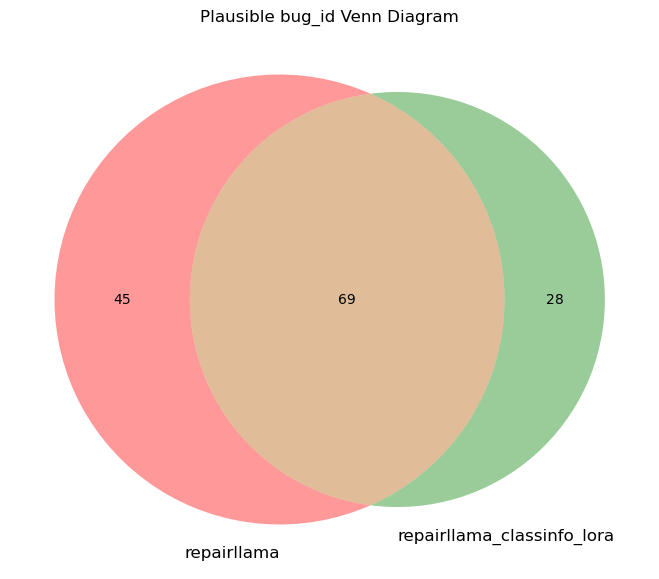

In [31]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# 示例res_dict，包含两个数据集的plausible bug_id
res = {
    'repairllama': {'plausible': res_dict['repairllama']['plausible']},
    'repairllama_classinfo_lora': {'plausible': res_dict['repairllama_classinfo_lora']['plausible']},
}

def draw_venn_for_plausible(res_dict):
    # 提取每个数据集中plausible的bug_id
    datasets_plausible = {dataset: data.get('plausible', []) for dataset, data in res.items()}
    
    # 计算重合与不重合的id数量
    # 由于示例中只有两个数据集，我们直接使用这两个数据集的名称
    dataset_names = list(datasets_plausible.keys())
    set1 = set(datasets_plausible[dataset_names[0]])
    set2 = set(datasets_plausible[dataset_names[1]])
    
    # 绘制维恩图
    plt.figure(figsize=(10, 7))
    venn2([set1, set2], set_labels=(dataset_names[0], dataset_names[1]))
    plt.title('Plausible bug_id Venn Diagram')
    plt.show()

# 调用函数绘制维恩图
draw_venn_for_plausible(res_dict)


In [26]:
import plotly.graph_objs as go

A = set(['a', 'b', 'c', 'd'])
B = set(['c', 'd', 'e', 'f'])
C = set(['c', 'f', 'g', 'h'])

fig = go.Figure(go.Venn(
    sets=[A, B, C],
    set_colors=('red', 'green', 'blue'),
    subset_colors=('pink', 'yellow', 'lightblue', 'orange', 'lightgreen', 'purple'),
    subset_label_formatter=lambda x: f"Label {x}"))

fig.show()

AttributeError: module 'plotly.graph_objs' has no attribute 'Venn'